In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt
import re #I import this library 'cause I need to deal with regular expressions
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer # para usar Yeo-Johnson
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
Api_file="Merged_Api.csv"
Api_df=pd.read_csv(Api_file)

In [3]:
Api_df['has_transitions']=Api_df['has_transitions'].astype('int')

In [4]:
Api_df

,id_band,score,name,has_transitions,albumCount,review_count
0,11143,0.500000,Cuntscrape,1,1.0,1
1,14768,0.770000,Psychiatric Regurgitation,1,1.0,1
2,16693,0.860000,Four Question Marks,1,2.0,1
3,16950,0.783333,Acranius,1,1.0,1
4,20572,0.550000,Emergency Gate,1,3.0,1
...,...,...,...,...,...,...
8090,60990,0.700000,Tidfall,0,1.0,4
8091,63005,0.700000,Emperor,0,1.0,4
8092,49377,0.680000,VARIOUS ARTISTS,0,1.0,6
8093,43600,0.680000,Valensia,0,1.0,6


In [5]:
Spotify_file='Spotify_extracted.csv'
Spotify_df=pd.read_csv(Spotify_file)

In [6]:
Spotify_df.columns

Index(['Name', 'Genres', 'Popularity', 'Followers', 'Artist_URI'], dtype='object')

In [7]:
Spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1000 non-null   object
 1   Genres      1000 non-null   object
 2   Popularity  1000 non-null   int64 
 3   Followers   1000 non-null   int64 
 4   Artist_URI  1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


## Imputación de los datos de score para los registros que provienen de la API de Spotify

Para realizar esta imputación de datos se busca extraer los valores de score de una distribución que respete el sesgo a la izquierda de los datos de Score originales y para esto se contemplaron dos caminos: el primero, consiste en utilizar una distribución log-normal e intentar reflejarla. Esto se plantea debido a que determinar los parámetros de esta distribución es relativamente sencillo, no obstante se desiste de este camino debido a que esta distrubución naturalmente tiene sesgo a la derecha. No obstante se deja el proceso reflejado en el notebook: 

In [8]:
Api_df['score'].describe()

count    8095.000000
mean        0.842687
std         0.148607
min         0.000000
25%         0.780000
50%         0.880000
75%         0.950000
max         1.000000
Name: score, dtype: float64

In [19]:
desired_mean = 0.842687
sigma = 0.148607
mu= np.log(desired_mean) - (sigma**2 / 2)

# Generar datos aleatorios con la distribución log-normal
data = np.random.lognormal(mean=mu, sigma=sigma, size=1000)

# Asegurarse de que los datos estén en el rango deseado [0, 1]
data_clipped = np.clip(data, 0, 1)

# Imprimir estadísticas básicas de los datos generados
print('Mean:', np.mean(data_clipped))
print('Std deviation:', np.std(data_clipped))
print('Min:', np.min(data_clipped))
print('Max:', np.max(data_clipped))

Mean: 0.8340240183305562
Std deviation: 0.10804736350608936
Min: 0.4864044873879608
Max: 1.0


<AxesSubplot: ylabel='Count'>

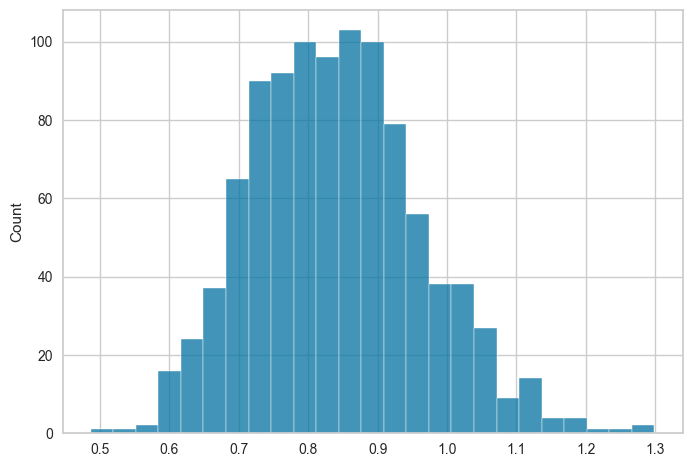

In [20]:
sns.histplot(data)

# Observaciones

Cómo se puede observar en el histplot anterior, la distrubución de los datos de la log-normal tiene sesgo a la derecha y no a la izquierda, de manera que se procede a usar la distribución Beta

# Imputación del Score usando la distrubución Beta:

La dsitrubución Beta es una distrubución que tiene sesgo a la izquierda y que depende de dos parámetros $\alpha$ y $\beta$. 
La **distribución Beta** es una familia de distribuciones de probabilidad definidas en el intervalo \([0, 1]\), parametrizadas por dos parámetros positivos que generalmente se denotan como $\alpha$ y $\beta$. La función de densidad de probabilidad (PDF) de una variable aleatoria Beta \(X\) se define como:

$$
f(x; \alpha, \beta) = \frac{x^{\alpha - 1}(1-x)^{\beta - 1}}{B(\alpha, \beta)}
$$

donde

$$
B(\alpha, \beta) = \int_{0}^{1} t^{\alpha - 1}(1-t)^{\beta - 1} dt
$$

es la función Beta, que sirve como constante de normalización para que el área bajo la curva de la PDF sea igual a 1.

La **media** $\mu$ y **varianza** $\sigma^2$ de la distribución Beta son:

$$
\mu = \frac{\alpha}{\alpha + \beta}
$$

$$
\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
$$

La forma de la distribución Beta puede variar ampliamente dependiendo de los valores de $\alpha$ y $\beta$, lo que la hace muy flexible para modelar datos con diferentes tipos de sesgos y concentraciones de probabilidad.

Para poder ajustar los párametros de la distribución Beta a los datos de Score de la db original y de esta forma obtener los datos que servirán para imputar los scores de las bandas que estén en la base de datos de la API, pero no en la base de datos original se procede de la siguiente forma:

# Primer Paso: obtener $\alpha$ y $\beta$ en terminos de $\alpha +\beta$ de las expresiones para la media y la varianza

De la expresión de la media podemos despejar $\alpha$ en terminos de $\alpha +\beta$ y nos arroja el siguiente resultado:

$$\alpha=\mu(\alpha +\beta)$$

Y para $\beta$ tenemos que:

$$\beta=\frac{\alpha(1-\mu)}{\mu}=\frac{\mu(\alpha +\beta)(1-\mu)}{\mu}=(\alpha +\beta)(1-\mu)$$

# Segundo paso: obtener  $\alpha +\beta$ de las expresión para la varianza

En la expresión de la varianza podemos sustituir el resultado obtenido anteriormente para $\alpha$ y $\beta$ en términos de $\alpha +\beta$:

$$
\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}= \frac{\mu(\alpha +\beta)(\alpha +\beta)(1-\mu)}{(\alpha + \beta)^2 (\alpha + \beta + 1)}=\frac{\mu(1-\mu)}{ (\alpha + \beta + 1)}
$$

Y de este resultado podemos encontrar que 

$$\alpha + \beta=\frac{\mu(1-\mu)}{\sigma^{2}}-1$$

Y ahora, si conocemos la varianza y la media podemos determinar $\alpha +\beta$ y con este párametro podemos calcular $\alpha$ y $\beta$ y con eso determinar nuestros párametros para la distribución beta. A partir de este punto llamaremos a $\alpha +\beta$ como tmp.

In [33]:
media = 0.842687  
varianza = 0.148607 ** 2  

# Calcular los parámetros alfa y beta
tmp = (media * (1 - media) / varianza) - 1
alfa = media * tmp
beta = (1 - media) * tmp

# Simular datos de una distribución beta
datos_simulados = np.random.beta(alfa, beta, size=1000)

# Verificar las propiedades de los datos simulados
print(f"Media simulada: {np.mean(datos_simulados)}")
print(f"Varianza simulada: {np.var(datos_simulados)}")

Media simulada: 0.8484208576244415
Varianza simulada: 0.02114534012627476


<AxesSubplot: ylabel='Count'>

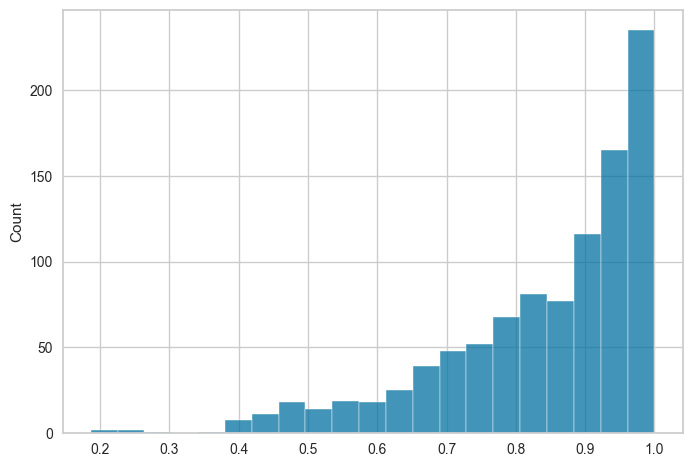

In [31]:
sns.histplot(datos_simulados)

In [29]:
Spotify_df['score']=Spotify_df.apply(lambda x:np.random.beta(alfa,beta),axis=1)

In [30]:
Spotify_df

,Name,Genres,Popularity,Followers,Artist_URI,score
0,Slayer,"alternative metal, death metal, groove metal, ...",64,3717516,spotify:artist:1IQ2e1buppatiN1bxUVkrk,0.984666
1,Gojira,"alternative metal, french death metal, french ...",61,1239549,spotify:artist:0GDGKpJFhVpcjIGF8N6Ewt,0.996419
2,Currents,"melodic metalcore, metalcore, progressive deat...",58,187066,spotify:artist:5pqvAI85RMxL9K0xHvSwGu,0.670290
3,In Flames,"alternative metal, gothenburg metal, melodic d...",61,1127923,spotify:artist:57ylwQTnFnIhJh4nu4rxCs,0.652000
4,Lorna Shore,"blackened deathcore, melodic metalcore, sympho...",57,540632,spotify:artist:6vXYoy8ouRVib302zxaxFF,0.874139
...,...,...,...,...,...,...
995,Cleansing of the Temple,"christian death metal, christian deathcore",5,1315,spotify:artist:4nNgrGNSI4M9ODTMH5MdNI,0.942668
996,Sentient Horror,swedish death metal,7,6037,spotify:artist:4MNbashXmMvEKIre76REzX,0.994068
997,Purulence,"british death metal, slam death metal",6,2317,spotify:artist:6n2vNeCnk8otr3DpmS6osE,0.986358
998,Emasculated Vituperation,slam death metal,7,916,spotify:artist:6JWlwpjP9WMxELrxX73n4h,0.793271


<AxesSubplot: xlabel='score', ylabel='Count'>

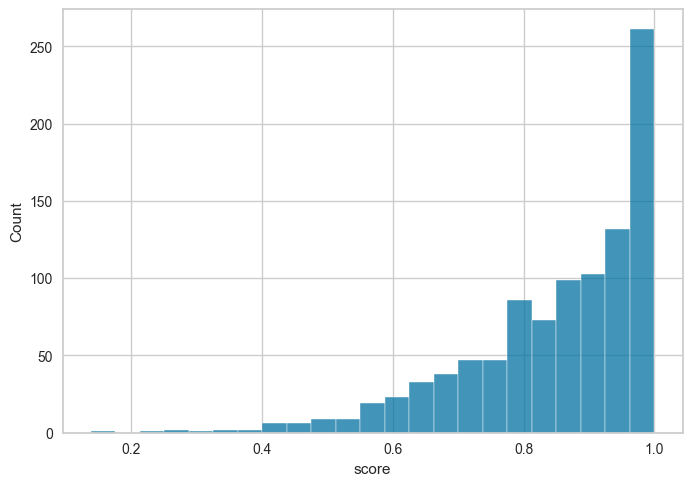

In [32]:
sns.histplot(Spotify_df['score'])